# Image similarity estimation using a Siamese Network with a contrastive loss

**Author:** Mehdi<br>
**Date created:** 2021/05/06<br>
**Last modified:** 2022/09/10<br>
**Description:** Similarity learning using a siamese network trained with a contrastive loss.

## Introduction

[Siamese Networks](https://en.wikipedia.org/wiki/Siamese_neural_network)
are neural networks which share weights between two or more sister networks,
each producing embedding vectors of its respective inputs.

In supervised similarity learning, the networks are then trained to maximize the
contrast (distance) between embeddings of inputs of different classes, while minimizing the distance between
embeddings of similar classes, resulting in embedding spaces that reflect
the class segmentation of the training inputs.

## Setup

In [116]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
from emnist import extract_training_samples

## Hyperparameters

In [117]:
epochs = 20
batch_size = 16
margin = 1  # Margin for contrastive loss.

## Load the MNIST dataset

In [118]:
#(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.emnist.load_data()

### https://pypi.org/project/emnist/ ###
### https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset ###

images, labels = extract_training_samples('mnist')

# Deep Learning Lecture: 60% training data, 20% validation data, 20% test data 
# balanced = 124800: 99840 = (74880 + 24960) ; 24960
# mnist = 60000: 48000 = (36000 + 12000) ; 12000

print(images.shape)
print(labels.shape)

x_train_val = images[:48000]
y_train_val = labels[:48000]
x_test = images[48000:]
y_test = labels[48000:]
                            
# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

(60000, 28, 28)
(60000,)


In [119]:
print(x_train_val.shape)
print(y_train_val.shape)
print(x_test.shape)
print(y_test.shape)

(48000, 28, 28)
(48000,)
(12000, 28, 28)
(12000,)


## Define training and validation sets

In [120]:
# Deep Learning Lecture: 60% training data, 20% validation data, 20% test data 
# 124800: 99840 = (74880 + 24960) ; 24960
x_train, x_val = x_train_val[:12000], x_train_val[12000:] # war vorher 4000, davor 30000 ;)
y_train, y_val = y_train_val[:12000], y_train_val[12000:]
del x_train_val, y_train_val

## Create pairs of images

We will train the model to differentiate between digits of different classes. For
example, digit `0` needs to be differentiated from the rest of the
digits (`1` through `9`), digit `1` - from `0` and `2` through `9`, and so on.
To carry this out, we will select N random images from class A (for example,
for digit `0`) and pair them with N random images from another class B
(for example, for digit `1`). Then, we can repeat this process for all classes
of digits (until digit `9`). Once we have paired digit `0` with other digits,
we can repeat this process for the remaining classes for the rest of the digits
(from `1` until `9`).

In [121]:

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

We get:

**pairs_train.shape = (60000, 2, 28, 28)**

- We have 60,000 pairs
- Each pair contains 2 images
- Each image has shape `(28, 28)`

Split the training pairs

In [122]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

Split the validation pairs

In [123]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

Split the test pairs

In [124]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]


## Visualize pairs and their labels

In [125]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Inspect training pairs

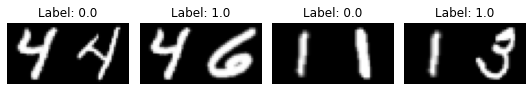

In [126]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Inspect validation pairs

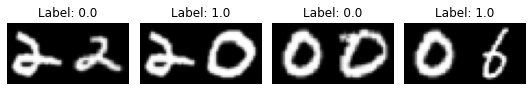

In [127]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

Inspect test pairs

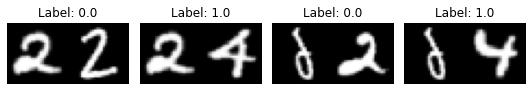

In [128]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

## Define the model

There are two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

In [129]:
# CONTRASTIVE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese1 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [130]:
# BCE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese2 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [131]:
# DICE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese3 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [132]:
# BCE + DICE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese4 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

## Define the contrastive Loss

In [133]:

def cont_loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


## Define the Dice Loss
https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras

In [141]:

def dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        dice_coef = 1 - dice
        
        return dice_coef
    
    return dice_coef_loss


## Define the BCE Loss
https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

In [142]:
# BCE_Dice_Loss
def BCE_loss(margin=1): #ignore margin

    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    
    return binary_cross_entropy_loss

## Define the BCE Dice Loss
https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

In [143]:
# BCE_Dice_Loss
def BCE_dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        return dice

    
    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    

    def BCE_dice_coef_loss(y_true, y_pred):
        dice_loss = 1 - dice_coef_loss(y_true, y_pred)
        BCE =  binary_cross_entropy_loss(y_true, y_pred)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE
    
    return BCE_dice_coef_loss

## Compile the model with the contrastive, dice, binary cross entropy, BCE Dice loss

In [144]:
# CONTRASTIVE
siamese1.compile(loss=cont_loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese1.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_18 (Functional)          (None, 10)           5318        ['input_29[0][0]',               
                                                                  'input_30[0][0]']               
                                                                                                  
 lambda_9 (Lambda)              (None, 1)            0           ['model_18[0][0]',        

In [145]:
# DICE
siamese2.compile(loss=dice_loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese2.summary()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_20 (Functional)          (None, 10)           5318        ['input_32[0][0]',               
                                                                  'input_33[0][0]']               
                                                                                                  
 lambda_10 (Lambda)             (None, 1)            0           ['model_20[0][0]',        

In [146]:
# BINARY CROSS ENTROPY LOSS
siamese3.compile(loss=BCE_loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese3.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_22 (Functional)          (None, 10)           5318        ['input_35[0][0]',               
                                                                  'input_36[0][0]']               
                                                                                                  
 lambda_11 (Lambda)             (None, 1)            0           ['model_22[0][0]',        

In [147]:
# BCE Dice
siamese4.compile(loss=BCE_dice_loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese4.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_24 (Functional)          (None, 10)           5318        ['input_38[0][0]',               
                                                                  'input_39[0][0]']               
                                                                                                  
 lambda_12 (Lambda)             (None, 1)            0           ['model_24[0][0]',        

## Train the model

In [148]:
# CONTRASTIVE

history1 = siamese1.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1131 - accuracy: 0.8472 - val_loss: 0.0594 - val_accuracy: 0.9239
Epoch 2/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0709 - accuracy: 0.9043 - val_loss: 0.0422 - val_accuracy: 0.9460
Epoch 3/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0571 - accuracy: 0.9262 - val_loss: 0.0340 - val_accuracy: 0.9564
Epoch 4/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0502 - accuracy: 0.9347 - val_loss: 0.0301 - val_accuracy: 0.9611
Epoch 5/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0462 - accuracy: 0.9405 - val_loss: 0.0243 - val_accuracy: 0.9689
Epoch 6/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0430 - accuracy: 0.9449 - val_loss: 0.0243 - val_accuracy: 0.9689
Epoch 7/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0383 - accuracy: 0.9508 - val_loss: 0.0215 - val_ac

In [149]:
# DICE

history2 = siamese2.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3025 - accuracy: 0.7652 - val_loss: 0.1181 - val_accuracy: 0.9111
Epoch 2/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1170 - accuracy: 0.9040 - val_loss: 0.0635 - val_accuracy: 0.9412
Epoch 3/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0859 - accuracy: 0.9225 - val_loss: 0.0470 - val_accuracy: 0.9548
Epoch 4/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0782 - accuracy: 0.9280 - val_loss: 0.0496 - val_accuracy: 0.9513
Epoch 5/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0774 - accuracy: 0.9268 - val_loss: 0.0401 - val_accuracy: 0.9599
Epoch 6/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0670 - accuracy: 0.9369 - val_loss: 0.0394 - val_accuracy: 0.9613
Epoch 7/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0671 - accuracy: 0.9370 - val_loss: 0.0405 - val_ac

In [150]:
# BINARY CROSS ENTROPY

history3 = siamese3.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.7383 - accuracy: 0.4880 - val_loss: 0.6949 - val_accuracy: 0.4923
Epoch 2/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6936 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.4954
Epoch 3/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.4950
Epoch 6/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.4965
Epoch 7/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_ac

In [151]:
# BCE DICE

history4 = siamese4.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.6300 - accuracy: 0.8405 - val_loss: 0.3444 - val_accuracy: 0.9134
Epoch 2/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3965 - accuracy: 0.9021 - val_loss: 0.2334 - val_accuracy: 0.9444
Epoch 3/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3086 - accuracy: 0.9253 - val_loss: 0.1649 - val_accuracy: 0.9619
Epoch 4/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2684 - accuracy: 0.9368 - val_loss: 0.1412 - val_accuracy: 0.9668
Epoch 5/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2293 - accuracy: 0.9458 - val_loss: 0.1171 - val_accuracy: 0.9717
Epoch 6/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2115 - accuracy: 0.9499 - val_loss: 0.1109 - val_accuracy: 0.9741
Epoch 7/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1867 - accuracy: 0.9567 - val_loss: 0.1004 - val_ac

## Visualize results

In [152]:

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

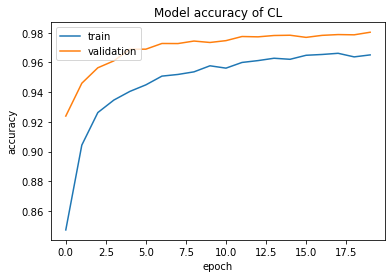

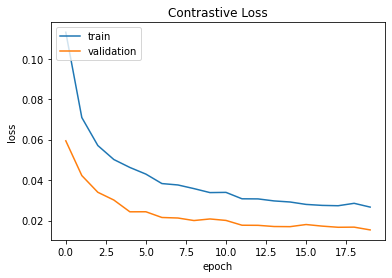

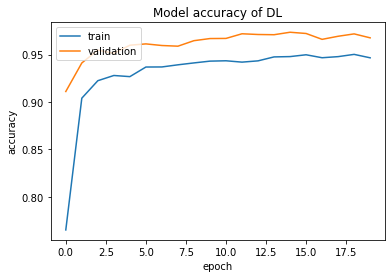

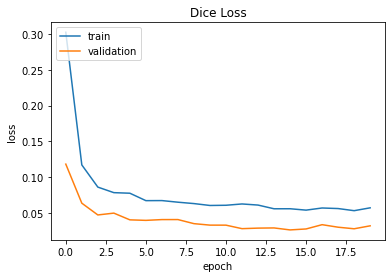

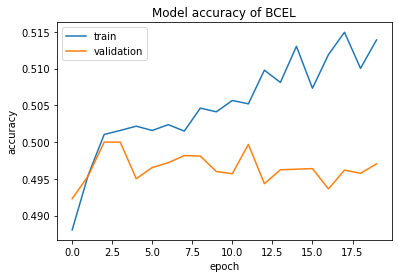

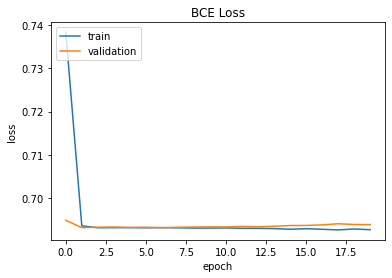

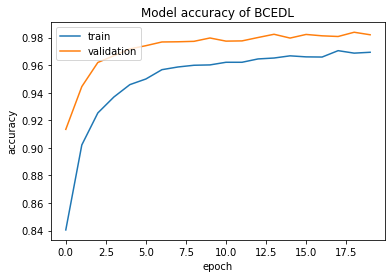

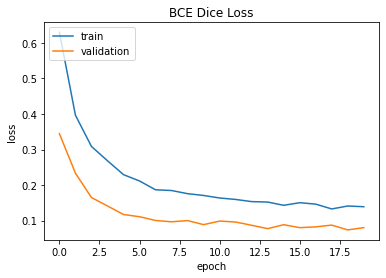

In [153]:
# Plot the accuracy of contrastive loss
plt_metric(history=history1.history, metric="accuracy", title="Model accuracy of CL")

# Plot the contrastive loss
plt_metric(history=history1.history, metric="loss", title="Contrastive Loss")

# Plot the accuracy of dice loss
plt_metric(history=history2.history, metric="accuracy", title="Model accuracy of DL")

# Plot the dice loss
plt_metric(history=history2.history, metric="loss", title="Dice Loss")

# Plot the accuracy of BCE loss
plt_metric(history=history3.history, metric="accuracy", title="Model accuracy of BCEL")

# Plot the BCE loss
plt_metric(history=history3.history, metric="loss", title="BCE Loss")

# Plot the accuracy of BCE dice loss
plt_metric(history=history4.history, metric="accuracy", title="Model accuracy of BCEDL")

# Plot the BCE dice loss
plt_metric(history=history4.history, metric="loss", title="BCE Dice Loss")

## Evaluate the model

In [154]:
# contrastive loss evaluation
results1 = siamese1.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results1)

750/750 [==============================] - 2s 2ms/step - loss: 0.0155 - accuracy: 0.9808
test loss, test acc: [0.015466056764125824, 0.9808333516120911]


In [155]:
# dice loss evaluation
results2 = siamese2.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results2)

750/750 [==============================] - 2s 2ms/step - loss: 0.0303 - accuracy: 0.9695
test loss, test acc: [0.030323876067996025, 0.9695416688919067]


In [156]:
# binary cross entropy loss evaluation
results3 = siamese3.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results3)

750/750 [==============================] - 2s 2ms/step - loss: 0.6941 - accuracy: 0.4943
test loss, test acc: [0.6940708160400391, 0.49433332681655884]


In [157]:
# bce dice loss evaluation
results4 = siamese4.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results4)

750/750 [==============================] - 2s 2ms/step - loss: 0.0837 - accuracy: 0.9819
test loss, test acc: [0.0837169960141182, 0.9818750023841858]


## More Metrics

In [ ]:
# From Deep Learning Lecture ex 6 on site

def compute_tp_tn_fn_fp(y_act, y_pred):
    y_act = pd.Series(y_act)
    y_pred = pd.Series(y_pred)
    tp = sum((y_act == 1) & (y_pred == 1))
    tn = sum((y_act == 0) & (y_pred == 0))
    fn = sum((y_act == 1) & (y_pred == 0))
    fp = sum((y_act == 0) & (y_pred == 1))
    return tp, tn, fp, fn

def compute_metrics(actual, predicted):
    # calculate the number of tp, fp, tn, fn
    tp, tn, fp, fn = compute_tp_tn_fn_fp(actual, predicted)
    # calculate the precision value (hint: multiply by 100 to get nice percentage values)
    acc = (tp + tn) / (tp + fp + tn + fn) * 100
    prec = tp / (tp + fp) * 100
    rec = tp / (tp + fn) * 100
    sens = tn / (tn + fp) * 100
    f1 = 2 * ((rec * prec) / (rec + prec))

    print('Accuracy: {}%; Precision: {}%; Recall: {}%; Sensitivity: {}%; F1-Score: {}%'.format(prec, prec, rec, sens, f1))

## Visualize the predictions

750/750 [==============================] - 1s 2ms/step


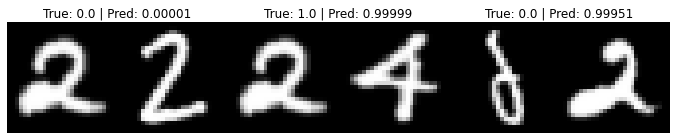

In [158]:
# contrastive loss evaluation
predictions1 = siamese1.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions1, test=True)

750/750 [==============================] - 1s 2ms/step


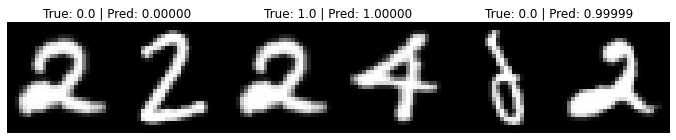

In [159]:
# dice loss evaluation
predictions2 = siamese2.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions2, test=True)

750/750 [==============================] - 1s 2ms/step


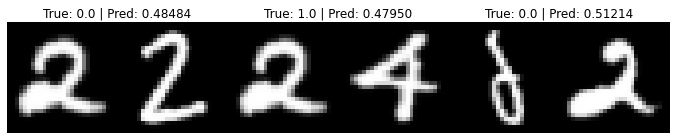

In [160]:
# binary cross entropy loss evaluation
predictions3 = siamese3.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions3, test=True)

750/750 [==============================] - 1s 2ms/step


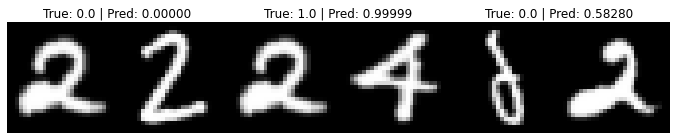

In [161]:
# Bce dice loss evaluation
predictions4 = siamese4.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions4, test=True)

## Other loss functions we may investigate or evaluate

### Cross Entropy with balance factor (2023)

### Multiple negative ranking loss (2022)

### Point wise loss (2007)

### Softmax cross entropy loss (2018)

### Max margin hinge loss (2021)

### Join of MSE, bidirectional Kullbakc Leibler dicergence and rank order of quality scores (2023)


**Example available on HuggingFace**
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-Siamese%20Network-black.svg)](https://huggingface.co/keras-io/siamese-contrastive) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-Siamese%20Network-black.svg)](https://huggingface.co/spaces/keras-io/siamese-contrastive) |